In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:24pt;}
div.text_cell_render.rendered_html{font-size:20pt;}
div.text_cell_render ul li, div.text_cell_render ol li p, code{font-size:22pt; line-height:30px;}
div.output {font-size:24pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:24pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:24pt;padding:5px;}
table.dataframe{font-size:24px;}
</style>
"""))

# ※ Quiz : 경주여행과 전주여행에 대해 최빈단어시각화와 유사도분석
- (1) naver open API를 활용하여 네이버지식인 "전주여행", "경주여행"를 각각 500건씩 검색 백업(naver.csv)
    * replace(), re.sum()이용
    * 백업 파일 결과 : query,no,title,link,description,total_text(title+' '+description)
- (2) 품사태깅 백업(naver_pos.csv)
    * query, no, token, pos
- (3) 명사만 추출 백업(naver_pos_nouns.csv)
    * query, token, pos
- (4) 빈도분석 백업(naver_pos_nouns_count.csv)
    * token, 경주빈도, 전주빈도, 빈도합
- (5) 빈도 시각화(워드클라우드, Text.plot)
    * 워드클라우드 이미지 저장
- (6) 단어간 유사도 분석(Word2Vec, 연관분석)

# 1. naver open API를 활용하여 검색어 500건 추출
- query,no,title,link,description,total_text(title+' '+description)

In [3]:
# .env 가져오기(방법1) - 추천
from dotenv import load_dotenv
import os
load_dotenv()
# print(os.getenv('CLIENT_ID'))
# print(os.getenv('CLIENT_SECRET'))

True

In [5]:
# .env 가져오기(방법2)
from decouple import config
# print(config('CLIENT_ID'))
# print(config('CLIENT_SECRET'))

In [8]:
# 네이버 검색 API 예제 - 블로그 검색
import os
import sys
import urllib.request
client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')
encText = urllib.parse.quote("경주 여행")
url = "https://openapi.naver.com/v1/search/blog?query=" + encText # JSON 결과
# url = "https://openapi.naver.com/v1/search/blog.xml?query=" + encText # XML 결과
request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
response = urllib.request.urlopen(request)
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    print(response_body.decode('utf-8')[:200])
else:
    print("Error Code:" + rescode)

{
	"lastBuildDate":"Tue, 02 Dec 2025 14:39:13 +0900",
	"total":1003198,
	"start":1,
	"display":10,
	"items":[
		{
			"title":"내 마음대로 기록하는 <b>경주여행<\/b> 2박3일",
			"link":"https:\/\/blog.naver.com\/hello


In [11]:
# 방법1
import requests
import pandas as pd
import json # response텍스트를 json스타일의 딕셔너리로
import re  # 정규표현식
from html import unescape # description에 &lt;등의 특수문자를 <(문자)로 변경

client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')
query = '경주 여행'
start = 1
headers = {
    'X-Naver-Client-Id':client_id,
    'X-Naver-Client-Secret':client_secret
}
# url = f'https://openapi.naver.com/v1/search/kin?query={query}&display=100&start={start}'
# response = requests.get(url, headers=headers)
url = 'https://openapi.naver.com/v1/search/kin'
params = {'query':query, 'display':100, 'start':start}
response = requests.get(url, params=params, headers=headers)
# print(response.text[:500])
# items = json.loads(response.text)['items']
items = response.json()['items']
print(len(items))

100

In [20]:
# title, link, description 추출(b태그삭제, 특수문자조정(&gt; -> >), 정규표현식을 이용한 한글추출 )
item = items[97]
title = item.get('title').replace('<b>', '').replace('</b>', '')
link = item['link']
description = item.get('description').replace('<b>', '').replace('</b>', '')
# html 특수 문자 처리
description = unescape(description)
# 정규표현식 : 알파벳, 숫자, 한글만 남기고 나머지는 제거
description = re.sub(r'[^a-zA-Z0-9가-힣]', ' ', description)
description = re.sub('\s+', ' ', description)
print(title, link, description)

경주 여행지 추천 https://kin.naver.com/qna/detail.naver?d1id=9&dirId=90111&docId=261370795&qb=6rK97KO8IOyXrO2WiQ==&enc=utf8  2 부산을 벗어난 경주 여행지 알려주세요 3 당일치기로 경주 여행코스 밑에 자세하게 권역별로 여행코스를 소개했습니다 경주여행이 처음이라면 대릉원 첨성대 참고로 쭈니아빠 블로그를 방문하시면 경주여행 


In [25]:
def get_search_element_return(query, start):
    headers = {
        'X-Naver-Client-Id':client_id,
        'X-Naver-Client-Secret':client_secret
    }
    # url = f'https://openapi.naver.com/v1/search/kin?query={query}&display=100&start={start}'
    # response = requests.get(url, headers=headers)
    url = 'https://openapi.naver.com/v1/search/kin'
    params = {'query':query, 'display':100, 'start':start}
    response = requests.get(url, params=params, headers=headers)
    # print(response.text[:500])
    # items = json.loads(response.text)['items']
    items = response.json()['items']
    result = []# 검색한 정보를 append할 리스트
    for i, item in enumerate(items):
        title = item.get('title').replace('<b>', ' ').replace('</b>', ' ')
        link  = item.get('link')
        description = item.get('description').replace('<b>', ' ').replace('</b>', ' ')
        # 특수문자처리
        description = unescape(description)
        # 영문자, 숫자, 한글을 제외한 문자 제거
        description = re.sub(r'[^a-zA-Z0-9가-힣]', ' ', description)
        description = re.sub('\s+', ' ', description)
        result.append({
            'query':query,
            'no':(start-1)*100 + i+1,
            'title':title,
            'link':link,
            'description':description,
            'total_text':title + ' ' +description
        })
    return result

In [34]:
import time
result_total = [] # 모든 검색 결과
queries = ['전주 여행', '경주 여행']
max_start = 5
for query in queries:
    for start in range(1, max_start+1):
        print(start, query, '읽는 중')
        result_total.extend(get_search_element_return(query, start))
        time.sleep(0.5)
df = pd.DataFrame(result_total)
df.to_csv('data/naver.csv', index=False)

1 전주 여행 읽는 중
2 전주 여행 읽는 중
3 전주 여행 읽는 중
4 전주 여행 읽는 중
5 전주 여행 읽는 중
1 경주 여행 읽는 중
2 경주 여행 읽는 중
3 경주 여행 읽는 중
4 경주 여행 읽는 중
5 경주 여행 읽는 중


# 2. 품사태깅 백업
- query, no, token, pos

In [35]:
import pandas as pd
df = pd.read_csv('data/naver.csv')
df.tail(1)

,query,no,title,link,description,total_text
999,경주 여행,500,경주여행 !!,https://kin.naver.com/qna/detail.naver?d1id=9&...,경주 여행 을 가려고 하는데 혹시 경주에 폴라로이드 카메라 대여 할 수 있는곳이나...,경주여행 !! 경주 여행 을 가려고 하는데 혹시 경주에 폴라로이드 카메라 대여 ...


In [42]:
df_list = df[['query','no','total_text']].values.tolist()
df_list[::500]

[['전주 여행',
  1,
  '25년10월5,6,7일  전주여행   전주여행 가볼만한 곳 추천부탁드립니다 25년 10월 초 전주여행 아이들과 함께 가기 좋은 시점이에요 추석에는 문 연 곳이 적을 수 있지만 전주 한옥마을이나 전주비빔밥 맛집은 추천해용 차는 밀릴 가능성이 높으니 미리 출발하는 '],
 ['경주 여행',
  1,
  'APEC 기간  경주여행  APEC 기간 경주여행 어떻게 생각하시나요 APEC 기간에 경주여행 은 좋은 방법이에요 역사와 문화가 가득한 도시에서 특별한 경험을 할 수 있을 거에요 즐거운 여행 되세요 ']]

In [51]:
from mecab import MeCab
analyzer = MeCab()
stopwords = {'전주', '경주', '여행'}
select_pos = ['NNG', 'NNP'] 
postagged_list = [] # query, no, token, pos 딕셔너리 list
for i, row in enumerate(df_list):
    query = row[0]
    no    = row[1]
    text  = row[2]
    tagged_text = analyzer.pos(text)
#     if i%250==0:
#         print("{}의 {}번째 품사태깅결과 : {}개".format(query, no, len(tagged_text)))
    for token, pos in tagged_text:
        # if token not in stopwords and pos in select_pos: # 불용어제외한 명사
        if token not in stopwords: # 불용어 제외.
            postagged_list.append({
                'query':query,
                'no':no,
                'token':token,
                'pos':pos
            })
df_postagged = pd.DataFrame(postagged_list)
df_postagged.to_csv('data/naver_pos.csv', index=False, encoding='cp949')

# 3. 명사만 추출

In [53]:
import pandas as pd
df_postagged = pd.read_csv('data/naver_pos.csv', encoding='cp949')
df_postagged.head(1)

,query,no,token,pos
0,전주 여행,1,25,SN


In [56]:
select_pos = ['NNG', 'NNP'] # mecab의 명사 pos tag
df_nouns = df_postagged[df_postagged['pos'].isin(select_pos)]
df_nouns.to_csv('data/naver_pos_nouns.csv', index=False, encoding='cp949')

# 4. 빈도분석
- token 경주빈도 전주빈도 빈도합

In [57]:
df_nouns = pd.read_csv('data/naver_pos_nouns.csv', encoding='cp949')
df_nouns.head()

,query,no,token,pos
0,전주 여행,1,곳,NNG
1,전주 여행,1,추천,NNG
2,전주 여행,1,부탁,NNG
3,전주 여행,1,아이,NNG
4,전주 여행,1,시점,NNG


In [59]:
df_nouns.groupby(['query','token'], as_index=False)['pos'].count()

,query,token,pos
0,경주 여행,가격,5
1,경주 여행,가능,30
2,경주 여행,가보세요,10
3,경주 여행,가본적,5
4,경주 여행,가시,5
...,...,...,...
996,전주 여행,효율,5
997,전주 여행,후,5
998,전주 여행,휴가,5
999,전주 여행,휴무,5


In [65]:
df_token_grp = df_nouns.groupby('query')['token'].value_counts()
df_token_grp = df_token_grp.reset_index(name='token_count')

In [66]:
df_token_grp.head()

,query,token,token_count
0,경주 여행,코스,447
1,경주 여행,추천,424
2,경주 여행,계획,151
3,경주 여행,곳,134
4,경주 여행,맛집,133


In [70]:
df_gj = df_token_grp.loc[df_token_grp['query']=='경주 여행', ['token','token_count']]
df_jj = df_token_grp.loc[df_token_grp['query']=='전주 여행', ['token','token_count']]
df_gj.shape, df_jj.shape

((535, 2), (466, 2))

In [71]:
df_gj.head()

,token,token_count
0,코스,447
1,추천,424
2,계획,151
3,곳,134
4,맛집,133


In [73]:
df_jj.head()

,token,token_count
535,코스,459
536,곳,433
537,봉,330
538,맛집,322
539,여수,315


In [82]:
#df_gj(경주 명사 출현횟수), df_jj(전주 명사 출현 횟수) 병합
import numpy as np
df_mrg = pd.merge(df_gj, df_jj, on='token', how='outer')
df_mrg.columns = ['token', '경주빈도', '전주빈도']
df_mrg.fillna(0, inplace=True)
df_mrg['경주빈도'] = df_mrg['경주빈도'].astype('int')
df_mrg['전주빈도'] = df_mrg['전주빈도'].astype(np.int32)
df_mrg.head(1)

,token,경주빈도,전주빈도
0,코스,447,459


In [88]:
df_mrg['빈도합'] = df_mrg['경주빈도']+df_mrg['전주빈도']
df_mrg['경주비율'] = df_mrg['경주빈도']/df_mrg['빈도합']
df_mrg['전주비율'] = df_mrg['전주빈도']/df_mrg['빈도합']
df_mrg['경주비율'] = df_mrg['경주비율'].apply(lambda x : "{:.2%}".format(x))
df_mrg['전주비율'] = df_mrg['전주비율'].apply(lambda x : "{:.2%}".format(x))
df_mrg.to_csv('data/naver_pos_nouns_count.csv', index=False, encoding='cp949')

# 5. 빈도 시각화(워드 클라우드, Text)
- 전주여행 워드클라우드/경주여행 워드클라우드

In [91]:
df_nouns = pd.read_csv('data/naver_pos_nouns.csv', encoding='cp949')
df_nouns.loc[::3000]

,query,no,token,pos
0,전주 여행,1,곳,NNG
3000,전주 여행,163,예상,NNG
6000,전주 여행,327,대중교통,NNG
9000,전주 여행,490,전문,NNG
12000,경주 여행,185,가족,NNG
15000,경주 여행,377,추천,NNG


In [100]:
df_gj_noun_list = df_nouns.loc[df_nouns['query']=='경주 여행', 'token'].to_list()
df_jj_noun_list = df_nouns.loc[df_nouns['query']=='전주 여행', 'token'].to_list()
gj_text = ' '.join(df_gj_noun_list)
jj_text = ' '.join(df_jj_noun_list)

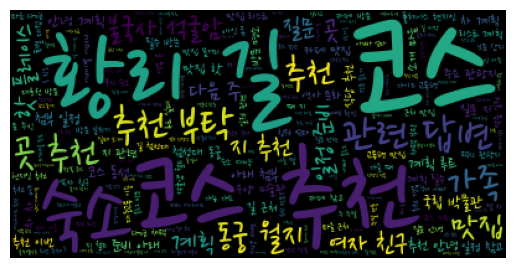

In [105]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
img = Image.open('data/heart.jpg')
mask = np.array(img)
불용어 = set()
wordcloud = WordCloud(
    font_path='data/NanumPenScript-Regular.ttf'
).generate(gj_text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()